In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Undergraduate_Thesis/data

Mounted at /gdrive
/gdrive/MyDrive/Undergraduate_Thesis/data


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
import itertools

In [ ]:
df = pd.read_csv("dengue_features_train.csv")
df.drop('precipitation_amt_mm', axis=1,inplace=True)
df.drop('week_start_date', axis=1,inplace=True)
df.dropna(inplace=True)


df_sj = df.loc[df['city'] == 'sj']
df_iq = df.loc[df['city'] == 'iq']
df_sj.drop('city', axis=1,inplace=True)
df_iq.drop('city', axis=1,inplace=True)
df_sj.describe

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
X=df_sj.iloc[:,0:21]
y=df_sj['total_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg_sj = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
reg_sj.fit(X_train, y_train)


y_pred = reg_sj.predict(X_test)
Act_vs_Pred_SJ = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(mean_absolute_error(y_test, y_pred))

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(Act_vs_Pred_SJ['Actual'],Act_vs_Pred_SJ['Predicted'])
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
Act_vs_Pred_SJ['Predicted'] = Act_vs_Pred_SJ['Predicted'].round(0)


print(Act_vs_Pred_SJ)
r2_score(y_test, y_pred)

5.853275426630377


0.06966591415160639

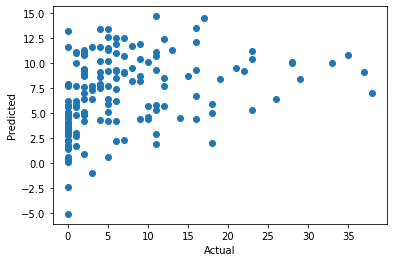

In [ ]:
X=df_iq.iloc[:,0:21]
y=df_iq['total_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg_iq = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
reg_iq.fit(X_train, y_train)


y_pred = reg_iq.predict(X_test)
Act_vs_Pred_IQ = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(mean_absolute_error(y_test, y_pred))

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(Act_vs_Pred_IQ['Actual'],Act_vs_Pred_IQ['Predicted'])
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
r2_score(y_test, y_pred)

In [ ]:
df_test = pd.read_csv("dengue_features_test.csv")
df_test.drop('precipitation_amt_mm', axis=1,inplace=True)
df_test.drop('week_start_date', axis=1,inplace=True)
df_test.dropna(inplace=True)


df_test_sj = df_test.loc[df_test['city'] == 'sj']
df_test_iq = df_test.loc[df_test['city'] == 'iq']
df_test_sj.drop('city', axis=1,inplace=True)
df_test_iq.drop('city', axis=1,inplace=True)
df_test_sj.describe

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<bound method NDFrame.describe of      year  weekofyear  ...  station_min_temp_c  station_precip_mm
0    2008          18  ...                21.7               75.2
1    2008          19  ...                22.2               34.3
4    2008          22  ...                23.3               84.1
5    2008          23  ...                25.0               27.7
6    2008          24  ...                23.3               91.7
..    ...         ...  ...                 ...                ...
255  2013          13  ...                22.8                3.5
256  2013          14  ...                22.8               17.6
257  2013          15  ...                23.3                9.4
258  2013          16  ...                23.9               22.9
259  2013          17  ...                21.7               47.5

[210 rows x 21 columns]>

In [ ]:
X=df_test_sj
y_pred_test_sj = reg_sj.predict(X)

X=df_test_iq.iloc[:,0:22]
y_pred_test_iq = reg_iq.predict(X)

In [ ]:
y = df_sj.total_cases
X = df_sj.drop(['total_cases'], axis=1)

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate r2
    X_train, X_test, y_train, y_test = train_test_split(X[list(feature_set)], y, test_size=0.33, random_state=42)
    model = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
    model.fit(X_train, y_train)
    r2 = r2_score(y_test,model.predict(X_test))
    #print(r2)
    return {"model":model, "r2":r2,"col":list(feature_set)}

def getBest(k):
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest r2
    best_model = models.loc[models["r2"].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_best = pd.DataFrame(columns=["r2", "model","col"])

tic = time.time()
for i in range(1,9):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

models_best

In [ ]:
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    #print(models)

    # Choose the model with the highest r2
    best_model = models.loc[models["r2"].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_fwd = pd.DataFrame(columns=["r2", "model","col"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["col"]
    print(models_fwd.loc[i]["r2"])

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
print(predictors)

Processed  21 models on 1 predictors in 0.12441420555114746 seconds.
0.07898751001147286
Processed  20 models on 2 predictors in 0.14253687858581543 seconds.
0.1259655436888475
Processed  19 models on 3 predictors in 0.13660740852355957 seconds.
0.1615659410639686
Processed  18 models on 4 predictors in 0.12915515899658203 seconds.
0.18387821442793695
Processed  17 models on 5 predictors in 0.1402428150177002 seconds.
0.18874981620534026
Processed  16 models on 6 predictors in 0.12904095649719238 seconds.
0.18876521054422724
Processed  15 models on 7 predictors in 0.12064504623413086 seconds.
0.18911787562991322
Processed  14 models on 8 predictors in 0.11644220352172852 seconds.
0.18814106243950068
Processed  13 models on 9 predictors in 0.12163662910461426 seconds.
0.19099188517046106
Processed  12 models on 10 predictors in 0.1065068244934082 seconds.
0.18600383102325646
Processed  11 models on 11 predictors in 0.08589816093444824 seconds.
0.1873786938830112
Processed  10 models on 

In [ ]:
norm_col = ["reanalysis_air_temp_k", "reanalysis_avg_temp_k","reanalysis_dew_point_temp_k","reanalysis_max_air_temp_k","reanalysis_min_air_temp_k","reanalysis_tdtr_k","station_avg_temp_c","station_diur_temp_rng_c","station_max_temp_c","station_min_temp_c"]

In [ ]:
def normalize(df):
  result = df.copy()
  for feature_name in norm_col:
      max_value = df[feature_name].max()
      min_value = df[feature_name].min()
      result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
  return result

In [ ]:
df_sj_norm = normalize(df_sj)
df_sj_norm
y = df_sj_norm.total_cases
X = df_sj_norm.drop(['total_cases'], axis=1)

models_fwd = pd.DataFrame(columns=["r2", "model","col"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["col"]
    print(models_fwd.loc[i]["r2"])

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
print(predictors)

Processed  21 models on 1 predictors in 0.11961627006530762 seconds.
0.07881099181535878
Processed  20 models on 2 predictors in 0.15456819534301758 seconds.
0.12465657897504534
Processed  19 models on 3 predictors in 0.14879989624023438 seconds.
0.1605510425153468
Processed  18 models on 4 predictors in 0.13873791694641113 seconds.
0.18144541812989667
Processed  17 models on 5 predictors in 0.1571340560913086 seconds.
0.18757811711640437
Processed  16 models on 6 predictors in 0.12446331977844238 seconds.
0.18870496008423887
Processed  15 models on 7 predictors in 0.12223339080810547 seconds.
0.18851613581508364
Processed  14 models on 8 predictors in 0.10635495185852051 seconds.
0.1889988275783493
Processed  13 models on 9 predictors in 0.1381218433380127 seconds.
0.18808998036405067
Processed  12 models on 10 predictors in 0.10333847999572754 seconds.
0.1880624734926738
Processed  11 models on 11 predictors in 0.09280824661254883 seconds.
0.1893406257816519
Processed  10 models on 1

In [ ]:
#eq = "total_cases ~ weekofyear + ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw + reanalysis_air_temp_k + reanalysis_avg_temp_k + reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k + reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + reanalysis_relative_humidity_percent + reanalysis_sat_precip_amt_mm + reanalysis_specific_humidity_g_per_kg + reanalysis_tdtr_k + station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c + station_min_temp_c + station_precip_mm"
#model = smf.glm(formula = eq, data=X_train, family=sm.families.NegativeBinomial()).fit()
#predictions = model.predict(X_test).astype(int)
#score = eval_measures.meanabs(predictions, X_test.total_cases)
#print(score)
#model.summary()